# Data and AI Democratization through PromptToQueryResult Function

In the context of data and AI democratization, `PromptToQueryResult` could be a function that translates natural language prompts into database queries. This could be part of a larger system that allows non-technical users to interact with databases using natural language, which would democratize access to data and AI.

## Business Value and Domain Problem Solutions

### Business Value:

- **Increased Efficiency:** Non-technical users can retrieve data without needing to learn SQL or other query languages, or without needing to wait for technical staff to retrieve the data for them.
- **Reduced Costs:** Less time and resources are spent on training staff to use complex database systems, and less time is spent on data retrieval tasks by technical staff.
- **Improved Decision Making:** With easier access to data, decision-making can be data-driven and timely, leading to better business outcomes.

### Domain Problem Solved:

- **Data Accessibility:** One of the challenges in data democratization is making data accessible to non-technical users. `PromptToQueryResult` could help solve this problem by providing a natural language interface to databases.
- **AI Democratization:** By using AI to translate natural language prompts into database queries, `PromptToQueryResult` could also contribute to AI democratization. It could be part of a system that allows users to leverage the power of AI without needing to understand the technical details.

## Implementation Details

The selected code is written in Python and it's part of a larger program that uses a plugin-based architecture. The code is using a kernel object to manage plugins and their functions.

- **Variable Definitions:** First, two variables are defined: `plugins_directory` and `file_path`. The `plugins_directory` variable is set to the string `"plugins"`, which is presumably the directory where the plugins are stored. The `file_path` variable is set to `"data_schema.txt"`, which is likely a file that contains a data schema.

- **Reading Data Schema:** The `read_data_schema_from_file` function is then called with `file_path` as an argument. This function reads the data schema from the specified file and returns it as a string. The returned data schema is stored in the `data_schema` variable.

- **Conditional Plugin Import:** Next, there's an if-statement that checks the `prompt_rephrase` variable. If `prompt_rephrase` is true, the code imports a plugin named `"PromptPlugin"` from the plugins directory using the `import_plugin_from_prompt_directory` method of the kernel object. This method returns a dictionary-like object of functions provided by the plugin. The `"PromptRephraser"` function from the `"PromptPlugin"` plugin is then stored in the `rephraserFunction` variable.

- **Function Invocation:** The `rephraserFunction` is then invoked asynchronously using the `invoke` method of the kernel object. The `invoke` method is called with two arguments: the function to be invoked and a `KernelArguments` object that contains the data schema and a query. The result of the function invocation is stored in the `rephrased_prompt` variable.

- **Importing Another Plugin:** Finally, the code imports another plugin named `"DataPlugin"` from the plugins directory and stores the `"DatabaseDescriptor"` function from this plugin in the `descriptorFunction` variable. This function can presumably be used later in the code to describe a database based on the data schema.


In [126]:
import semantic_kernel as sk
from services import Service
import re
import sqlite3
import pandas as pd
import os
from dotenv import dotenv_values
import semantic_kernel.connectors.ai.hugging_face as sk_hf
import datetime
import json
from huggingface_hub import InferenceApi
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from pydantic import BaseModel  # Import Pydantic BaseModel
import requests  # Import requests library

async def GenerateQuestions(selectedService=Service.AzureOpenAI):
    """
    Generates possible questions using the Semantic Kernel and prints the results.
    """
    kernel = sk.Kernel()
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    elif selectedService == Service.HuggingFace:
        from huggingface_hub import InferenceApi
    
        api_token = "your_huggingface_api_token"  # Set your HuggingFace API token here
        model_id = "huggingface-model-id"  # Set the model ID you want to use from HuggingFace
        
        hf_service = InferenceApi(repo_id=model_id, token=api_token)
        service_id = "hf_chat_completion"
        kernel.add_service(
            HuggingFaceChatCompletion(service_id=service_id, hf_service=hf_service),
        )
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    queryGeneratorFunction = promptFunctions["QuestionGenerator"]
    result = await kernel.invoke(queryGeneratorFunction, sk.KernelArguments(data_schema=data_schema))
    result_string = result.data if hasattr(result, 'data') else str(result)
    # Generate a unique filename based on the current date
    filename = "questions/" + datetime.datetime.now().strftime("%Y-%m-%d") + ".txt"

    # Write result_string to the file
    with open(filename, 'w') as file:
        file.write(result_string)

    # Print the filename
    print("Result saved to:", filename)
    print(result_string)

async def ReadQuestionsAndGenerateAnswers(filename, debug=False, selectedService=Service.AzureOpenAI):
    """
    Reads questions from a file and generates answers using the Semantic Kernel.

    Args:
        filename (str): The name of the file containing the questions.

    """
    with open(filename, 'r') as file:
        content = file.read()

    # Extract the filename from the full path
    filename = os.path.basename(filename)

    # Remove the file extension
    filename = os.path.splitext(filename)[0]

    # Create the directory path
    directory_path = "answers/" + filename 

    print("Directory path: ", directory_path)   

    # Create the directory if it does not exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    

    data = json.loads(content)
    i = 0
    for item in data:
        complexity = item["complexity"]
        queries = item["queries"]
        
        for question in queries:
            print("Index:" , i)
            print("Question: ", question)
            print("Complexity: ", complexity)
            questionFolderName = i.__str__() + "_" + complexity
            if not os.path.exists(directory_path + "/"  + questionFolderName + "/"):
                os.makedirs(directory_path + "/"  + questionFolderName + "/")

            try:
                await PromptToQueryResult(debug=debug, prompt_rephrase=False, selectedService=selectedService, query=question, outputFileDir=directory_path + "/" + questionFolderName + "/")
            except Exception as e:
                error_message = str(e)
                with open(directory_path + "/" + questionFolderName + "/error.txt", "w") as file:
                    file.write(error_message)
            i = i + 1

def make_safe_folder_name(folder_name):
    # Define a regular expression pattern to match invalid characters
    # This example replaces anything that is not a letter, number, underscore, or hyphen with an underscore
    safe_folder_name = re.sub(r'[^A-Za-z0-9_\-]', '_', folder_name)
    return safe_folder_name

async def PromptToQueryResult(debug=False, prompt_rephrase=False, selectedService=Service.AzureOpenAI, query=None, outputFileDir="", huggingface_model="Llama318BInstruct"):
    """
    Prompts the user for a query, rephrases the prompt if required, and executes the query using the Semantic Kernel.

    Args:
        debug (bool, optional): If True, prints debug information. Defaults to False.
        prompt_rephrase (bool, optional): If True, rephrases the prompt using a rephraser plugin. Defaults to False.

    Returns:
        DataFrame or any: The result of the executed query, or 'any' if no query is executed.
    """
    kernel = sk.Kernel()
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    elif selectedService == Service.HuggingFace:
        from huggingface_hub import InferenceApi
        model_id, api_token, api_url = hugging_face_settings_from_dot_env_llama318BInstruct(huggingface_model)
        # api_token = "hf_..."  # Set your HuggingFace API token here
        # model_id = "meta-llama/Llama-3.1-8B-Instruct"  # Set the model ID you want to use from HuggingFace
        # api_url = f"https://api-inference.huggingface.co/models/{model_id}/v1/chat/completions"
        # Initialize the HuggingFace Inference API without task override
        hf_service = InferenceApi(repo_id=model_id, token=api_token)
    

       # Define a simple completion object to hold both the response and metadata
        class CompletionResult:
            def __init__(self, content: str, metadata: dict = None):
                self.content = content
                self.metadata = metadata or {}

            def __iter__(self):
                return iter([self.content])  # Ensures CompletionResult can be iterated over

        # Create the HuggingFaceChatCompletion class with a custom request
        class HuggingFaceChatCompletion(ChatCompletionClientBase, BaseModel):
            service_id: str
            api_token: str
            api_url: str
            
            class Config:
                arbitrary_types_allowed = True

            async def complete_async(self, messages: list, max_tokens: int = 500, stream: bool = False, **kwargs):
                # Create the headers and payload for the request
                headers = {
                    "Authorization": f"Bearer {self.api_token}",
                    "Content-Type": "application/json"
                }

                payload = {
                    "model": self.api_url.split('/')[-4],  # model_id
                    "messages": messages,
                    "max_tokens": max_tokens,
                    "stream": stream
                }

                # Make the request to HuggingFace API
                response = requests.post(self.api_url, headers=headers, json=payload)
                response_json = response.json()

                # Log the response for debugging
                # print("HuggingFace API Response:", response_json)
                
                # Handle the response format
                if "choices" in response_json:
                    content = response_json["choices"][0]["message"]["content"]
                    # Return a list of CompletionResult objects, even if there's only one
                    return [CompletionResult(content=content, metadata={"model": self.ai_model_id})]
                    #return content
                else:
                    raise ValueError(f"Unexpected response format: {response_json}")

            # Updated complete_chat to handle chat_history and settings
            async def complete_chat(self, chat_history, settings, **kwargs):
                messages = [{"role": "user", "content": msg.content} for msg in chat_history]
                return await self.complete_async(messages)
            
            # Implement required complete_chat_stream method
            async def complete_chat_stream(self, chat_history, settings, **kwargs):
                # For non-streaming models, we can return the entire result as one chunk
                result = await self.complete_chat(chat_history, settings)
                for chunk in [result]:  # Mock streaming by yielding the entire result as a single chunk
                    yield chunk

        service_id = "hf_chat_completion"
        kernel.add_service(
            HuggingFaceChatCompletion(service_id=service_id, api_token=api_token, api_url=api_url, ai_model_id=model_id),
        )

    
    if(query is None):
        query = input("Enter your query: ")  # Get query from user
    rephrased_prompt = query
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    if(prompt_rephrase):
        promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "PromptPlugin")
        rephraserFunction = promptFunctions["PromptRephraser"]
        rephrased_prompt_result = await kernel.invoke(rephraserFunction, sk.KernelArguments(data_schema=data_schema, query=query))
        # Debug: Print the type and value of the result to understand its structure
        # print(type(rephrased_prompt_result))  # This will show whether it's a tuple, list, or other type
        # print(rephrased_prompt_result)        # This will print the raw result
        # print("Kernel invoke result:", rephrased_prompt_result.__dict__)
        if(hasattr(rephrased_prompt_result, 'data')):
            rephrased_prompt = rephrased_prompt_result.data
        elif (rephrased_prompt_result.__dict__):
            # Access the value (which contains the list of CompletionResult objects)
            # print("Value: ", rephrased_prompt_result.value)
            completion_results = rephrased_prompt_result.value

            # Check if it's a list and access the content of the first CompletionResult
            if isinstance(completion_results, list) and len(completion_results) > 0:
                first_result = completion_results[0]
                # print(first_result.content)  # This will print the content of the first result
                rephrased_prompt = first_result.content
            else:
                print("No completion results found.")
        else:
            rephrased_prompt = str(rephrased_prompt_result)
        #rephrased_prompt = rephrased_prompt_result.data if hasattr(rephrased_prompt_result, 'data') else str(rephrased_prompt_result)

    dataFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    descriptorFunction = dataFunctions["DatabaseDescriptor"]

    savePlotToDisk = ""
    if(outputFileDir != ""):
        savePlotToDisk = "Generated plots should be saved in the directory: " + outputFileDir + "plot.png"

    if(outputFileDir != ""):
        # Write rephrased prompt to query.txt file
        with open(outputFileDir + "user_prompt.txt", "w") as file:
            file.write(rephrased_prompt)

    result = await kernel.invoke(descriptorFunction, sk.KernelArguments(data_schema=data_schema, query= rephrased_prompt, save_plot_to_disk = savePlotToDisk))
    if(hasattr(result, 'data')):
        result_string = result.data
    elif (result.__dict__):
        # Access the value (which contains the list of CompletionResult objects)
        # print("Value: ", result.value)
        completion_results = result.value

        # Check if it's a list and access the content of the first CompletionResult
        if isinstance(completion_results, list) and len(completion_results) > 0:
            first_result = completion_results[0]
            # print(first_result.content)  # This will print the content of the first result
            result_string = first_result.content
        else:
            print("No completion results found.")
    else:
        result_string = str(result)
    if(debug):
        print("result String:", result_string)
    matches_sql = parse_text_between_tags(result_string,"<sql>", "</sql>")

    if(prompt_rephrase):
        print("User query: " + query)
    print("Rephrased prompt: " + rephrased_prompt + "#")
    if len(matches_sql) > 0:
        sql = matches_sql[0]
        if(outputFileDir != ""):
            # Write query to .txt file
            with open(outputFileDir + "sql_query.txt", "w") as file:
                file.write(sql)
        if debug:
            print("SQL: ", sql)
        df = run_sql_query(sql)
    
    

    matches_python = parse_text_between_tags(result_string,"<python>", "</python>")
    if len(matches_python) > 0:
        if debug:
            print("PYTHON:", matches_python[0])
        try:
            db_conn = os.getenv("DB_CONNECTION_STRING")
            conn = sqlite3.connect(db_conn)
            exec(matches_python[0])
            conn.close()

            if(outputFileDir != ""):
                # Write python code to .txt file
                with open(outputFileDir + "python_code.txt", "w") as file:
                    file.write(matches_python[0])

        except Exception as e:
            if debug:
                print('hata:' + e)
        except:
            print("An exception occurred")
    if len(matches_sql) > 0:
        df.head()
        if(outputFileDir != ""):
            df.to_csv(outputFileDir + "output.csv", index=False)
        return df
    else:  
        return any

def hugging_face_settings_from_dot_env_llama318BInstruct(p_model="Llama318BInstruct") :

    config = dotenv_values(".env")
    model_name = config.get("HUGGINGFACE_MODEL_NAME_" + p_model, None)
    api_key = config.get("HUGGINGFACE_API_KEY", None)
    api_url = config.get("HUGGINGFACE_API_URL_" + p_model, None)
    return model_name, api_key, api_url

def read_data_schema_from_file(file_path):
    """
    Reads the data schema from a file.

    Args:
        file_path (str): The path to the file containing the data schema.

    Returns:
        str: The contents of the file as a string.

    Raises:
        FileNotFoundError: If the file does not exist.

    """
    with open(file_path, 'r') as file:
        data_schema = file.read()
    return data_schema

def parse_text_between_tags(text, start_tag, end_tag):
    """
    Parses the text between the specified start and end tags.

    Args:
        text (str): The text to search within.
        start_tag (str): The start tag to look for.
        end_tag (str): The end tag to look for.

    Returns:
        list: A list of matches found between the start and end tags.
    """
    pattern = rf"{re.escape(start_tag)}(.*?){re.escape(end_tag)}"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def run_sql_query(query):
    """
    Executes the given SQL query and returns the result as a pandas DataFrame.

    Parameters:
    query (str): The SQL query to be executed.

    Returns:
    pandas.DataFrame: The result of the SQL query as a DataFrame.
    """
    db_conn = os.getenv("DB_CONNECTION_STRING")
    conn = sqlite3.connect(db_conn)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df



In [ ]:
await GenerateQuestions()

In [ ]:
await ReadQuestionsAndGenerateAnswers(filename="questions/2024-06-23.txt", selectedService=Service.HuggingFace, debug=False)

result String: <sql>
SELECT 
    C.category_name AS Product_Category,
    SUM(OI.quantity) AS Sales_Volume
FROM 
    orders O
JOIN 
    order_items OI ON O.order_id = OI.order_id
JOIN 
    products P ON OI.product_id = P.product_id
JOIN 
    categories C ON P.category_id = C.category_id
GROUP BY 
    C.category_name
ORDER BY 
    Sales_Volume DESC
LIMIT 5;
</sql>

<python>
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'product_id': [1,2,3,4,5,6],
    'product_name': ['Trek', 'Ritchey', 'Surly', 'Electra', 'Giant', 'Mountain'],
    'category_id': [1, 1, 1, 2, 2, 3],
   'model_year': [2016, 2016, 2016, 2016, 2016, 2016],
    'list_price': [100, 200, 300, 400, 500, 600],
    'quantity': [250, 200, 180, 150, 120, 100],
   'revenue': [95000, 80000, 72000, 60000, 48000, 55000],
    'category_name': ['Children Bicycles', 'Comfort Bicycles', 'Road Bicycles', 'Mountain Bikes', 'Kids Bikes', 'Ultralight Bikes']
})

df = df.groupby('category_name')['quantity'].sum()

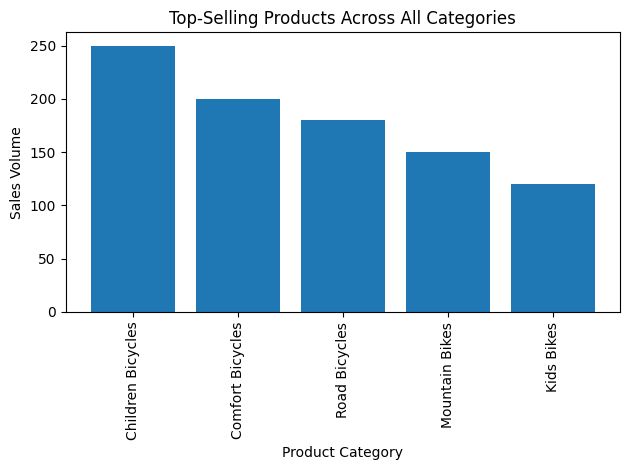

Top 5 Best-Selling Products:
    category_name  quantity
Children Bicycles       250
 Comfort Bicycles       200
    Road Bicycles       180
   Mountain Bikes       150
       Kids Bikes       120


,Product_Category,Sales_Volume
0,Cruisers Bicycles,2063
1,Mountain Bikes,1755
2,Children Bicycles,1179
3,Comfort Bicycles,813
4,Road Bikes,559


In [128]:
await PromptToQueryResult(prompt_rephrase=True, debug=True ,selectedService=Service.HuggingFace, huggingface_model="Llama318BInstruct")
